# Data Preprocessing for AQUA-RAT Dataset

## Introduction
In this notebook, we will preprocess the AQUA-RAT dataset to prepare it for training our student-teacher model. The preprocessing steps include loading the data, cleaning, tokenizing, and preparing the dataset for model training.

In [1]:
import pandas as pd
import numpy as np
from transformers import T5Tokenizer, AutoTokenizer
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
TRAIN_DATA_PATH = "../../data/AQuA/train.json"
TEST_DATA_PATH = "../../data/AQuA/test.json"
VAL_DATA_PATH = "../../data/AQuA/dev.json"
TRAIN_PREPROCESSED_PATH = "../../data/preprocessed/AquA-preprocessed-train.pt"
TEST_PREPROCESSED_PATH = "../../data/preprocessed/AquA-preprocessed-test.pt"
VAL_PREPROCESSED_PATH = "../../data/preprocessed/AquA-preprocessed-val.pt"

### Load Data
- Train set = train.json
- Test set  = test.json
- Validation set = dev.json 

In [3]:
train_data_raw = []
test_data_raw = []
val_data_rev = []
with open(TRAIN_DATA_PATH, "r") as file:    
    for line in file:
        train_data_raw.append(json.loads(line))
with open(TEST_DATA_PATH, "r") as file:    
    for line in file:
        test_data_raw.append(json.loads(line))
with open(VAL_DATA_PATH, "r") as file:    
    for line in file:
        val_data_rev.append(json.loads(line))

### Data Inspection
Take a look on train data

In [4]:
for element in train_data_raw[:10]:
    print(json.dumps(element, indent=4))

{
    "question": "Two friends plan to walk along a 43-km trail, starting at opposite ends of the trail at the same time. If Friend P's rate is 15% faster than Friend Q's, how many kilometers will Friend P have walked when they pass each other?",
    "options": [
        "A)21",
        "B)21.5",
        "C)22",
        "D)22.5",
        "E)23"
    ],
    "rationale": "If Q complete x kilometers, then P completes 1.15x kilometers.\nx + 1.15x = 43\n2.15x=43\nx = 43/2.15 = 20\nThen P will have have walked 1.15*20=23 km.\nThe answer is E.",
    "correct": "E"
}
{
    "question": "In the coordinate plane, points (x, 1) and (5, y) are on line k. If line k passes through the origin and has slope 1/5, then what are the values of x and y respectively?",
    "options": [
        "A)4 and 1",
        "B)1 and 5",
        "C)5 and 1",
        "D)3 and 5",
        "E)5 and 3"
    ],
    "rationale": "Line k passes through the origin and has slope 1/5 means that its equation is y=1/5*x.\nThus: (x, 

## Transforming to pandas

In [5]:
train_df = pd.DataFrame(train_data_raw)
test_df = pd.DataFrame(test_data_raw)
val_df = pd.DataFrame(val_data_rev)
train_df.head()

,question,options,rationale,correct
0,"Two friends plan to walk along a 43-km trail, ...","[A)21, B)21.5, C)22, D)22.5, E)23]","If Q complete x kilometers, then P completes 1...",E
1,"In the coordinate plane, points (x, 1) and (5,...","[A)4 and 1, B)1 and 5, C)5 and 1, D)3 and 5, E...",Line k passes through the origin and has slope...,C
2,"For all numbers p and q, the operation @ is de...","[A)II, B)I and II, C)I and III, D)II and III, ...",p@q = p^2 - pq=p(p-q).... so p@q will be zero ...,B
3,Carl is facing very difficult financial times ...,"[A)$1600, B)$2000, C)$2150, D)$2500, E)$12000]","Usually, you are given the annual rate of inte...",A
4,The speed at which a man can row a boat in sti...,"[A)18 seconds, B)27 seconds, C)26 seconds, D)1...",Speed of the boat downstream = 25 +11\n= 36 km...,E


### Load Tokenizer
- Student
    - t5-small
        - https://huggingface.co/google-t5/t5-small 
- Teacher
    - Llemma_7b
        - https://huggingface.co/EleutherAI/llemma_7b
    - gpt-neo-2.7B
        - https://huggingface.co/EleutherAI/gpt-neo-2.7B

In [6]:
t5_tokenizer = T5Tokenizer.from_pretrained('google-t5/t5-small')
llemma_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/llemma_7b")
gptneo_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-2.7B")

teacher_tokenizers = {
    'llemma': llemma_tokenizer,
    'gptneo': gptneo_tokenizer,
}

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can

## Analyze Optimal max_length

Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


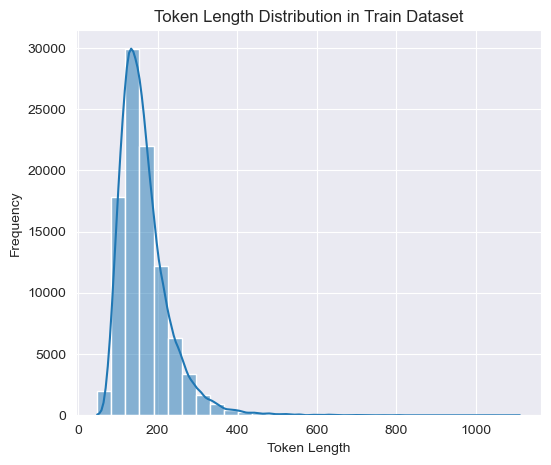

Train Dataset Length Statistics:
Max length: 1111
90th percentile length: 244.0
95th percentile length: 283.0
Average length: 166.3366677952538


In [7]:
def calculate_token_lengths(df):
    lengths = []
    for index, row in df.iterrows():
        question_text = f"Question: {row['question']} Options: {row['options']}"
        rationale_text = f"Rationale: {row['rationale']}"
        question_tokens = t5_tokenizer(question_text, return_tensors='pt')['input_ids']
        rationale_tokens = t5_tokenizer(rationale_text, return_tensors='pt')['input_ids']
        total_length = question_tokens.size(1) + rationale_tokens.size(1)
        lengths.append(total_length)
    
    return lengths

train_lengths = calculate_token_lengths(train_df)
test_lengths = calculate_token_lengths(test_df)
val_lengths = calculate_token_lengths(val_df)

def plot_length_distribution(lengths, dataset_name):
    plt.figure(figsize=(6, 5))
    sns.histplot(lengths, bins=30, kde=True)
    plt.title(f'Token Length Distribution in {dataset_name} Dataset')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.show()

plot_length_distribution(train_lengths, "Train")

def get_length_statistics(lengths):
    print(f"Max length: {max(lengths)}")
    print(f"90th percentile length: {np.percentile(lengths, 90)}")
    print(f"95th percentile length: {np.percentile(lengths, 95)}")
    print(f"Average length: {np.mean(lengths)}")

print("Train Dataset Length Statistics:")
get_length_statistics(train_lengths)

## Tokenize Data

In [8]:
def preprocess_data_for_models(df, max_length=256):
    teacher_inputs = {key: [] for key in teacher_tokenizers.keys()}
    student_inputs = []

    for index, row in df.iterrows():
        question_text = f"Question: {row['question']} Options: {row['options']}"
        rationale_text = f"Rationale: {row['rationale']}"

        student_question_encoding = t5_tokenizer(question_text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        student_rationale_encoding = t5_tokenizer(rationale_text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)

        # Student tokens
        student_inputs.append({
            'input_ids': student_question_encoding['input_ids'].squeeze(),
            'attention_mask': student_question_encoding['attention_mask'].squeeze(),
            'rationale_ids': student_rationale_encoding['input_ids'].squeeze(),
            'rationale_attention_mask': student_rationale_encoding['attention_mask'].squeeze(),
            'correct_index': ord(row['correct']) - ord('A')
        })

        for teacher_name, tokenizer in teacher_tokenizers.items():
            # Ensure that the tokenizer has a padding token
            if tokenizer.pad_token is None:
                tokenizer.pad_token = tokenizer.eos_token

            question_encoding = tokenizer(question_text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
            rationale_encoding = tokenizer(rationale_text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)

            # Teacher tokens
            teacher_inputs[teacher_name].append({
                'input_ids': question_encoding['input_ids'].squeeze(),
                'attention_mask': question_encoding['attention_mask'].squeeze(),
                'rationale_ids': rationale_encoding['input_ids'].squeeze(),
                'rationale_attention_mask': rationale_encoding['attention_mask'].squeeze(),
                'correct_index': ord(row['correct']) - ord('A')
            })

    return teacher_inputs, student_inputs

In [9]:
train_teacher_inputs, train_student_inputs= preprocess_data_for_models(train_df)
torch.save({
        'student_inputs': train_teacher_inputs,
        'teacher_inputs': train_student_inputs
    }, TRAIN_PREPROCESSED_PATH)
print(f"Preprocessed data saved to {TRAIN_PREPROCESSED_PATH}")

Preprocessed data saved to ../../data/preprocessed/AquA-preprocessed-train.pt


In [10]:
train_teacher_inputs['llemma'][0]

{'input_ids': tensor([    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,   

In [11]:
# test_teacher_inputs, test_student_inputs = preprocess_data_for_models(test_df)
# torch.save({
#     'student_inputs': test_student_inputs,
#     'teacher_inputs': test_teacher_inputs
# }, TEST_PREPROCESSED_PATH)
# print(f"Preprocessed test data saved to {TEST_PREPROCESSED_PATH}")

Preprocessed test data saved to ../../data/preprocessed/AquA-preprocessed-test.pt


In [12]:
# val_teacher_inputs, val_student_inputs = preprocess_data_for_models(val_df)
# torch.save({
#     'student_inputs': val_student_inputs,
#     'teacher_inputs': val_teacher_inputs
# }, VAL_PREPROCESSED_PATH)
# print(f"Preprocessed validation data saved to {VAL_PREPROCESSED_PATH}")

Preprocessed validation data saved to ../../data/preprocessed/AquA-preprocessed-val.pt
